# Topic modeling, topic assignment and sentiment analysis 

Most of the data on the web is in some form of free format. This means it's both unstructured and unlabeled, making it challenging to process and analyze. Furthermore, processing it might involve labeling data one document, one text bit, one comment at a time, which is labor intensive, time consuming and not something we're looking forward to. 

This project will demo techniques that perform unsupervised learning on a large corpus of unstructured text:
    1.  will determine the clusterings topics using NMF (Non-negative Matrix Factorization). The topics will be represented as numbers. They will provide the most common words associated with that clustering. It will be up to us to name that topic something meaningful. This is the only work involving human judgement. It's not necessary - it will only help with the readability and also with judging the quality of unsupervised machine topic modelling.
    2.  after the clustering, will do the topic assignment for each comment in the corpus
    3.  last step involves analyzing each comment for polarity sentiment and intensity of emotion using an NLTK library called VADER - Valence Aware Dictionary for sEntiment Reasoning
    
For those who like using enterprise BI tools, there will be a section of processing and distributing it in PowerBI

Let's get started

## Import the libraries

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

## Import data

In [8]:
# get data in its entirety
all_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

# take conversation data only
data = all_data.data

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

# Peeking at the data

At this point we have imported the data. How useful is it? Well, we can examine each comment one by one like this:

In [40]:
print(data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Or we can do some statistics on it and it would look like this:

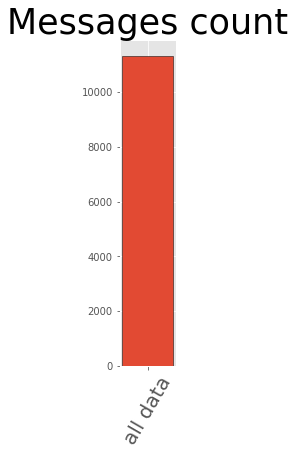

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(1,6))

y = df['topic name'].value_counts()
plt.bar(x='all data', height=len(data), edgecolor = 'k')
plt.xticks(rotation=60, fontsize = 20)
plt.title('Messages count', fontsize = 35)
plt.show()

That's pretty much all the insights we can derive without machine intervention.

## Vectorize text

Messages come in different sizes. To be fed into an ML algorithm, they need to be cleaned and standardized. For NMF we'll use an tfidf vectorizer which normalizes the term frequency wrt the number of documents.

In [9]:
# convert the text to a tf-idf weighted term-document matrix
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, stop_words='english')
X = vectorizer.fit_transform(data)
idx_to_word = np.array(vectorizer.get_feature_names())

## Cluster documents by topics

This is the point when we manually set how many topics are we interested in. Just like any other unsupervised ML algorithm (K-means clustering for example or LDA etc), it requires an element of human decision

In [10]:
# We already know there are 20 topics. 
# In general, the boundaries between topics are not set -we can decide ourselves how many topics we want

n_topics = len(all_data.target_names)

nmf = NMF(n_components=n_topics, beta_loss = 'kullback-leibler', solver="mu", random_state = 42)
W = nmf.fit_transform(X)
H = nmf.components_

## Examine the clusterings

In [11]:
# examine the clusterings for topic naming
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: say,things,thing,point,sure,don,way,people,want,time
Topic 2: info,advance,need,looking,hi,does,mail,help,know,thanks
Topic 3: true,bible,christians,life,word,christian,religion,jesus,believe,god
Topic 4: clipper,information,rights,law,used,state,key,use,public,government
Topic 5: used,problems,computer,software,disk,problem,hard,use,work,drive
Topic 6: 15,email,following,send,university,shipping,offer,edu,interested,sale
Topic 7: window,version,running,run,problem,program,file,use,windows,using
Topic 8: league,teams,win,players,season,play,games,team,game,year
Topic 9: won,good,doesn,soon,really,use,ll,don,sure,edu
Topic 10: old,test,small,power,bike,new,stuff,car,good,used
Topic 11: vga,price,cards,drivers,support,driver,does,monitor,card,video
Topic 12: times,problem,left,ago,way,does,long,right,years,time
Topic 13: heard,maybe,going,seen,right,thought,tell,got,ve,just
Topic 14: really,state,year,right,make,good,let,don,think,people
Topic 15: great,old,sounds,know,people,lo

## Create a mapping between the algorithm generated topics and our understanding of their meaning

In [12]:
# create a mapping between the topics and the top words determining that clustering
topic_key = [i for i in range(n_topics)]
topic_value = ['misc', 'help info', 'christianity', 'public interest', 'hardware', 'university', 'windows OS', 'sports', 'edu', 'for sale', 'comp graphics', 'past events', 'of interest', 'sports2', 'news', 'jobs', 'sports3', 'space', 'sports4', 'middle east']

topic_dict = dict(zip(topic_key, topic_value))
topic_dict

{0: 'misc',
 1: 'help info',
 2: 'christianity',
 3: 'public interest',
 4: 'hardware',
 5: 'university',
 6: 'windows OS',
 7: 'sports',
 8: 'edu',
 9: 'for sale',
 10: 'comp graphics',
 11: 'past events',
 12: 'of interest',
 13: 'sports2',
 14: 'news',
 15: 'jobs',
 16: 'sports3',
 17: 'space',
 18: 'sports4',
 19: 'middle east'}

## Topic assignment to individual messages

Create a mapping between the document index and the topics inferred

In [13]:
# the topic cluster is the argmax along the columns
index=[]
nmf_topic=[]

for i, t in enumerate(W):
    index.append(i)
    m = t.argsort()[-1]
    nmf_topic.append(m)

In [45]:
import pandas as pd
df  = pd.DataFrame([nmf_topic, data]).T
df.columns=['topic number', 'comments']
print(df.shape)
print(df.head(3))

(11314, 2)
  topic number                                           comments
0            9  I was wondering if anyone out there could enli...
1            4  A fair number of brave souls who upgraded thei...
2           12  well folks, my mac plus finally gave up the gh...


## Add our topic names next to the machine generated topics

In [46]:
df['topic name'] = pd.Categorical(df['topic number']).rename_categories(topic_dict)
df.head(3)

,topic number,comments,topic name
0,9,I was wondering if anyone out there could enli...,for sale
1,4,A fair number of brave souls who upgraded thei...,hardware
2,12,"well folks, my mac plus finally gave up the gh...",of interest


## Re-arrange the columns

In [47]:
cols = ['topic number', 'topic name', 'comments']
df = df[cols]
df.head(3)

,topic number,topic name,comments
0,9,for sale,I was wondering if anyone out there could enli...
1,4,hardware,A fair number of brave souls who upgraded thei...
2,12,of interest,"well folks, my mac plus finally gave up the gh..."


## Remove blanks and nans

In [48]:
blanks = []
for ix, t, rv, t2 in df.itertuples():
    if type(rv)== str:
        if rv.isspace():
            blanks.append(ix)

df.drop(blanks, inplace =True)
print(df.shape)
print(df.head(2))

(11314, 3)
  topic number topic name                                           comments
0            9   for sale  I was wondering if anyone out there could enli...
1            4   hardware  A fair number of brave souls who upgraded thei...


# Sentiment Analysis - intuition and necessity

As it is, we already accomplished a pretty significant task: we organized the data into topic structures. We can now make judgments such as "what's the most popular topic?"

Let's take another peek at our data after topic modeling:

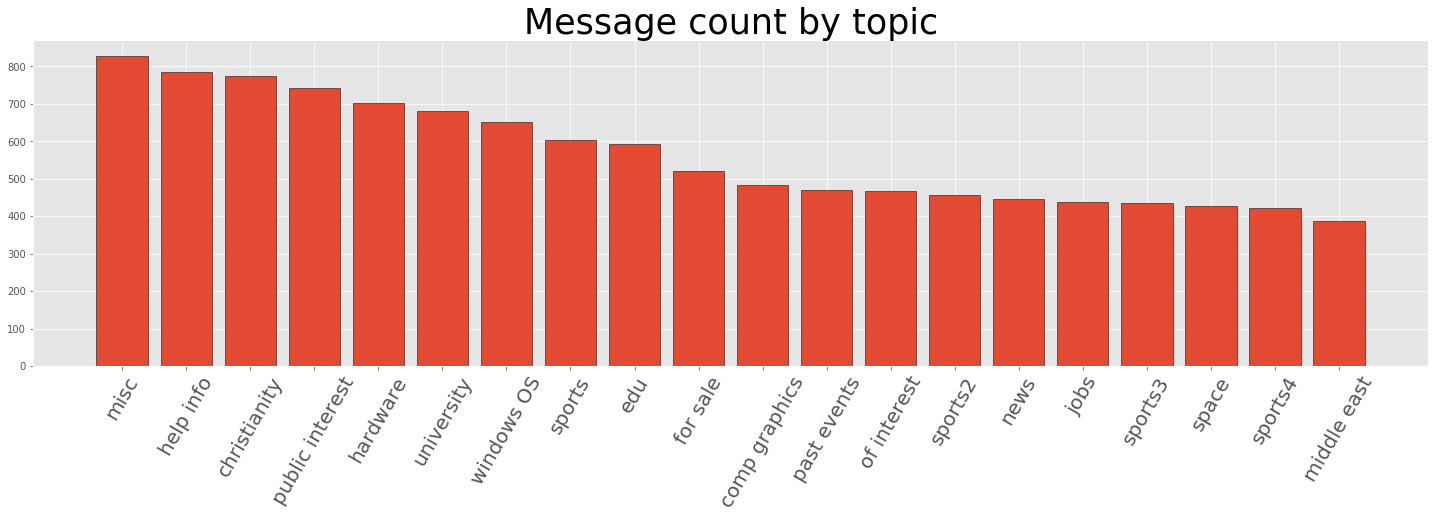

In [49]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(25,6))
x_axis = topic_value
y = df['topic name'].value_counts()
plt.bar(x=x_axis, height=y, edgecolor = 'k')
plt.xticks(rotation=60, fontsize = 20)
plt.title('Message count by topic', fontsize = 35)
plt.show()

But wouldn't be even more amazing if we could somehow get some insight into this data without reading a line from the original messages?

# Meet VADER - Valence Aware Dictionary for sEntiment Reasoning

VADER is a model used for sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is part of the NLTK package and can be applied directly to unlabeled text data

In [42]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\D\Anaconda4\envs\nlp_course\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [50]:
sid = SentimentIntensityAnalyzer()

## First sentiment data

In [51]:
df['comprehensive score'] = df['comments'].apply(lambda comment: sid.polarity_scores(comment))
df.head(3)

,topic number,topic name,comments,comprehensive score
0,9,for sale,I was wondering if anyone out there could enli...,"{'neg': 0.017, 'neu': 0.92, 'pos': 0.063, 'com..."
1,4,hardware,A fair number of brave souls who upgraded thei...,"{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp..."
2,12,of interest,"well folks, my mac plus finally gave up the gh...","{'neg': 0.024, 'neu': 0.873, 'pos': 0.104, 'co..."


The scores have a negative, neutral, positive and compounded component. Let's zero in the compounded component

In [52]:
df['score'] = df['comprehensive score'].apply(lambda score: score['compound'])
df.head(3)

,topic number,topic name,comments,comprehensive score,score
0,9,for sale,I was wondering if anyone out there could enli...,"{'neg': 0.017, 'neu': 0.92, 'pos': 0.063, 'com...",0.6249
1,4,hardware,A fair number of brave souls who upgraded thei...,"{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp...",0.9468
2,12,of interest,"well folks, my mac plus finally gave up the gh...","{'neg': 0.024, 'neu': 0.873, 'pos': 0.104, 'co...",0.9761


In [53]:
mean_scores_by_topic = df.groupby('topic number')['score'].mean()
df['topic mean score'] = df['topic number'].apply(lambda x: mean_scores_by_topic[x] )
df.head(3)

,topic number,topic name,comments,comprehensive score,score,topic mean score
0,9,for sale,I was wondering if anyone out there could enli...,"{'neg': 0.017, 'neu': 0.92, 'pos': 0.063, 'com...",0.6249,0.379360
1,4,hardware,A fair number of brave souls who upgraded thei...,"{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp...",0.9468,0.277856
2,12,of interest,"well folks, my mac plus finally gave up the gh...","{'neg': 0.024, 'neu': 0.873, 'pos': 0.104, 'co...",0.9761,0.153930


Let's get the corpus average score so that we can contrast each category with the corpus

In [54]:
corpus_mean_score = df['score'].mean()
df['corpus mean score'] = corpus_mean_score
df.head(3)

,topic number,topic name,comments,comprehensive score,score,topic mean score,corpus mean score
0,9,for sale,I was wondering if anyone out there could enli...,"{'neg': 0.017, 'neu': 0.92, 'pos': 0.063, 'com...",0.6249,0.379360,0.248971
1,4,hardware,A fair number of brave souls who upgraded thei...,"{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp...",0.9468,0.277856,0.248971
2,12,of interest,"well folks, my mac plus finally gave up the gh...","{'neg': 0.024, 'neu': 0.873, 'pos': 0.104, 'co...",0.9761,0.153930,0.248971


### Summarize the progress with a plot

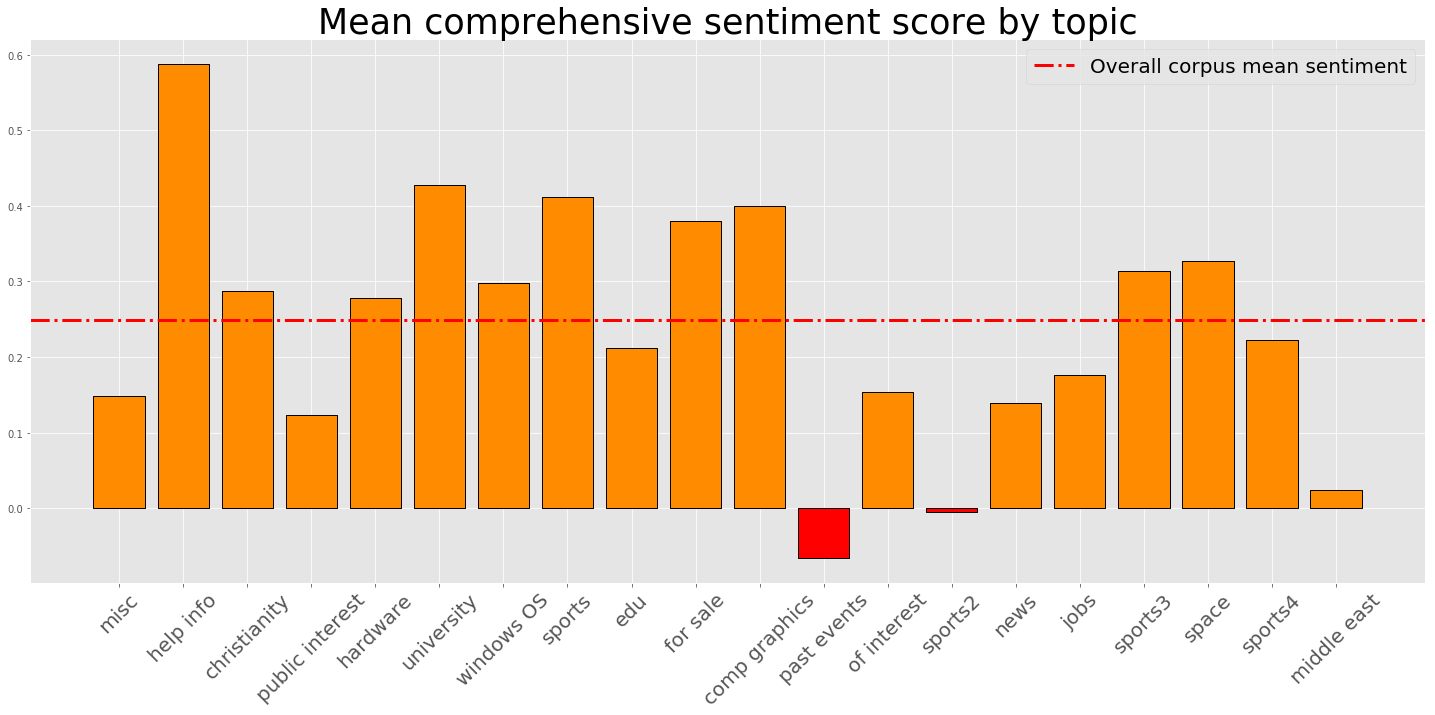

In [61]:
colors = []
for i in mean_scores_by_topic:
    if i>=0:
        colors.append('darkorange')
    else:
        colors.append('r')
plt.figure(figsize=(25,10))
plt.title('Mean comprehensive sentiment score by topic', fontsize=35)
plt.bar(x_axis, height = mean_scores_by_topic, color=colors, edgecolor='k', lw=1)
plt.axhline(corpus_mean_score, linestyle='-.', color = 'r', lw=3, label='Overall corpus mean sentiment')
plt.xticks(rotation=45, fontsize=20)
plt.legend(fontsize=20)
plt.show()

The information extracted from our data at this point is night and day different from our starting point. Why stop here or now? Let's see what else we can get from our data without reading a single line from the conversation boards.

## Compress the score's continuous values into a categorical label with values pos, neg, neutral

In [62]:
df['label'] = df['score'].apply(lambda x: 'pos' if x >=.3 else ('neg' if x<-.3 else 'neutral'))
df.head(3)

,topic number,topic name,comments,comprehensive score,score,topic mean score,corpus mean score,label
0,9,for sale,I was wondering if anyone out there could enli...,"{'neg': 0.017, 'neu': 0.92, 'pos': 0.063, 'com...",0.6249,0.379360,0.248971,pos
1,4,hardware,A fair number of brave souls who upgraded thei...,"{'neg': 0.0, 'neu': 0.801, 'pos': 0.199, 'comp...",0.9468,0.277856,0.248971,pos
2,12,of interest,"well folks, my mac plus finally gave up the gh...","{'neg': 0.024, 'neu': 0.873, 'pos': 0.104, 'co...",0.9761,0.153930,0.248971,pos


In [63]:
df['label'].value_counts()

pos        6199
neg        2570
neutral    2545
Name: label, dtype: int64

Text(0.5, 1.0, 'Distribution of score labels')

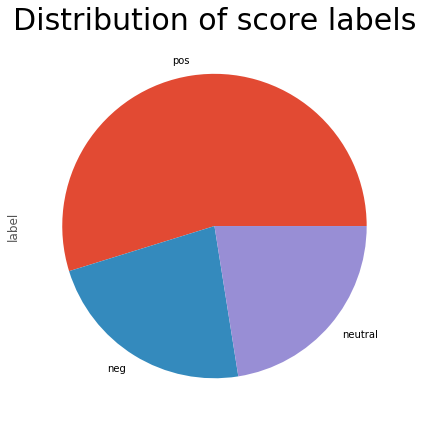

In [72]:
plot = df['label'].value_counts().plot.pie( figsize=(7, 7))
plt.title('Distribution of score labels', fontsize=30)

We can see that most comments are positive. Let's group by topic and see what we can infer at that level of resolution

In [66]:
# group by topics and extract the label distribution
labels_by_topic = df[['topic name', 'label']].groupby('topic name')['label'].value_counts()
level0 = labels_by_topic.unstack()
df0=pd.DataFrame(level0).reset_index()
df0 = df0.reset_index()

pos = df0['pos']
neg = df0['neg']
neutral = df0['neutral']

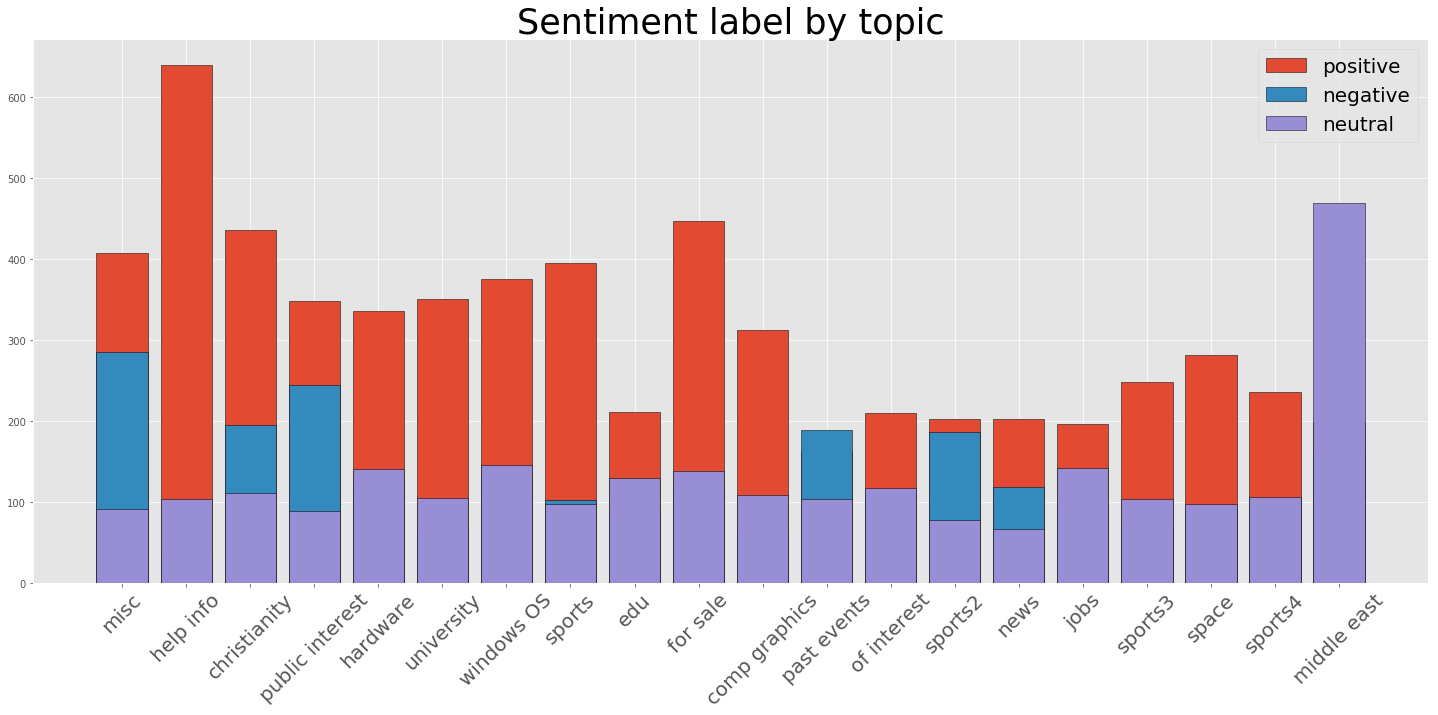

In [68]:
plt.figure(figsize=(25,10))
p1 = plt.bar(x_axis, pos, edgecolor='k')
p2 = plt.bar(x_axis, neg, edgecolor='k')
p3 = plt.bar(x_axis, neutral, edgecolor='k')
plt.title('Sentiment label by topic', fontsize=35)
plt.legend((p1[0],p2[0],p3[0]), ('positive','negative', 'neutral'), fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.show()

# Final thoughts:

We have taken an unstructured corpus of data and applied **Non-Negative Matrix Factorization** to extract the topics based on the topics' latent representation through words. We have then merged the obtained topic categories back with the corpus to map each text entry with a topic. Using **VADER** - Valence Aware Dictionary for sEntiment Reasoning - an NLTK library, we then proceeded to mine the corpus for additional insights. 

*David Bowie would have been impressed. Or at least Starman, I think... But I've been known to be wrong once or twice before*